In [1]:
import pandas as pd 
import numpy as np
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_array_morlet
from scipy.ndimage import gaussian_filter

# Load Signal

In [2]:
df = np.load('signal.npy')

In [3]:
print(df)
print(df.shape)

[[-6.24999984e-06 -4.29687498e-06 -3.71093756e-06 ...  6.93359380e-06
   5.07812501e-06  5.95703114e-06]
 [-3.17382801e-05 -3.49609363e-05 -3.76953139e-05 ...  6.00585954e-05
   6.02539076e-05  6.12304721e-05]]
(2, 32769)


# Raw Signal

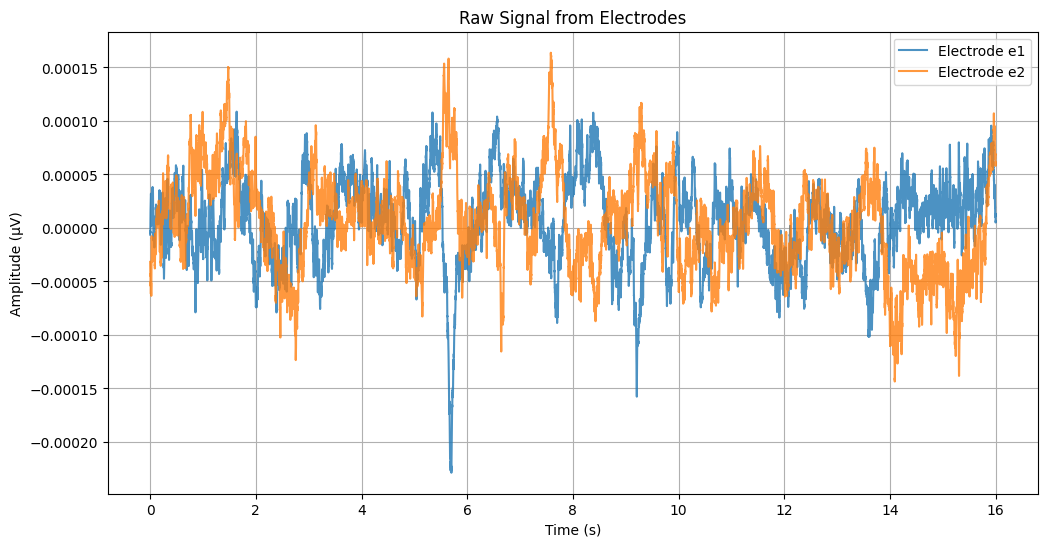

In [4]:
e1_raw = df[0, :]
e2_raw = df[1, :]
time = np.arange(0, len(e1_raw)) / 2048

plt.figure(figsize=(12, 6))
plt.plot(time, e1_raw, label="Electrode e1", alpha=0.8)
plt.plot(time, e2_raw, label="Electrode e2", alpha=0.8)
plt.title("Raw Signal from Electrodes")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.grid()
plt.show()

# Bipolar Derivation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(32769,)


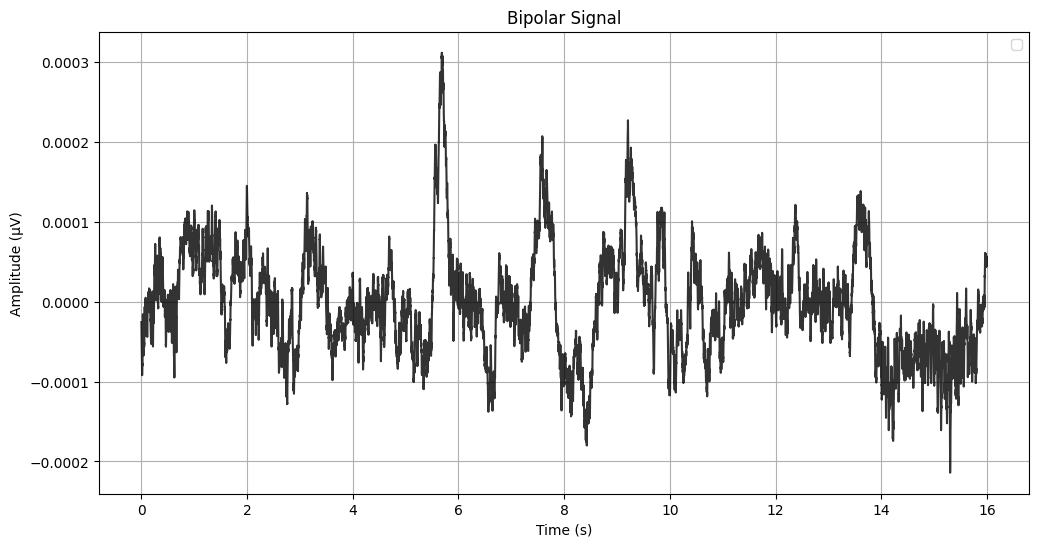

In [5]:
# To perform a bipolar derivation between two electrodes (e.g., e1 and e2),
# we subtract the signal of one electrode from the other at each corresponding time point.

bipolar_signal = df[1, :] - df[0, :]

print(bipolar_signal.shape)
bipolar_signal

plt.figure(figsize=(12, 6))
plt.plot(time, bipolar_signal, alpha=0.8, color='black')
plt.title("Bipolar Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.grid()
plt.show()

# Applying Filter

In [6]:
fs = 2048  # Sampling frequency in Hz
low_cutoff = 4  # High-pass cutoff frequency in Hz
high_cutoff = 100  # Low-pass cutoff frequency in Hz
order = 4  # Filter order

# Design the band-pass filter
nyquist = 0.5 * fs  # Nyquist frequency
low = low_cutoff / nyquist
high = high_cutoff / nyquist

b, a = signal.butter(order, [low, high], btype='band')

filtered_signal = signal.filtfilt(b, a, bipolar_signal)

#  Power spectrum with welsh method

In [7]:
frequencies, psd = signal.welch(bipolar_signal, fs=fs, nperseg=2048)
print("Frequencies shape:", frequencies.shape)
print("PSD shape:", psd.shape)

Frequencies shape: (1025,)
PSD shape: (1025,)


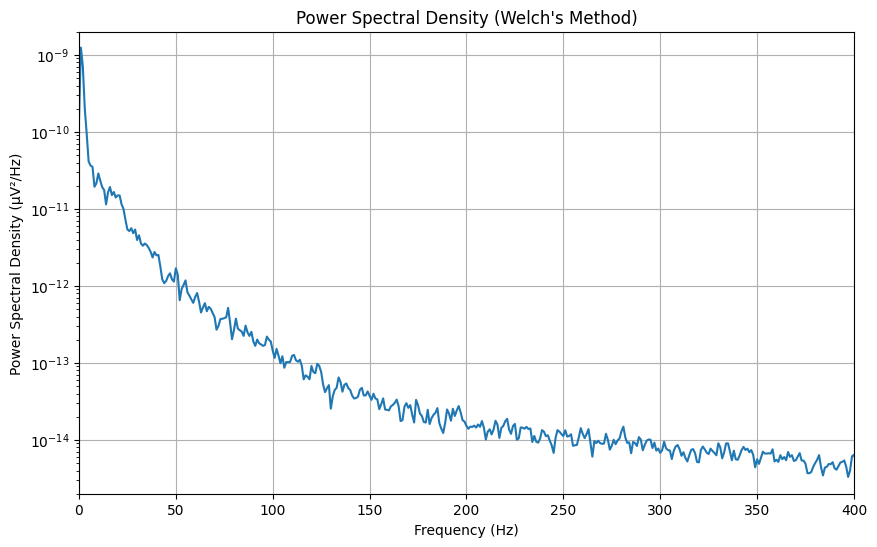

In [28]:
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd)
plt.title("Power Spectral Density (Welch's Method)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (μV²/Hz)")
plt.grid(True)
plt.xlim([0, 400])
plt.ylim([2e-15, 2e-9])
plt.show()

# time-frequency decomposition with tfr_array_morlet 

In [42]:
frequencies = np.logspace(np.log10(4), np.log10(100), num=40)  # Log-spaced frequencies
n_cycles = frequencies / 2  # Number of cycles per frequency

# Reshape filtered_signal to (n_epochs, n_chans, n_times)
reshaped_signal = filtered_signal[np.newaxis, np.newaxis, :]

tfr = tfr_array_morlet(reshaped_signal, sfreq=2048, freqs=frequencies, n_cycles=n_cycles, output='power')



In [43]:
baseline = tfr.mean(axis=-1, keepdims=True)  # Compute average across time
tfr_baselined = tfr / baseline  # Normalize


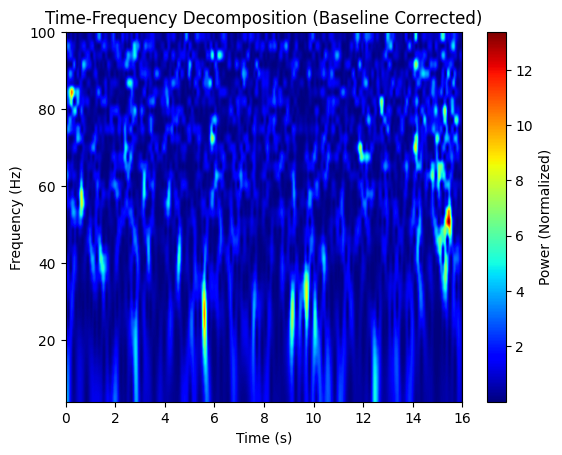

In [44]:
plt.figure()
plt.imshow(tfr_baselined[0, :, :].squeeze(), aspect='auto', cmap='jet', origin='lower',
           extent=[0, filtered_signal.shape[-1] / 2048, frequencies[0], frequencies[-1]])
plt.colorbar(label='Power (Normalized)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Decomposition (Baseline Corrected)')
plt.show()
